In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load specific forecasting tools
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df = pd.read_csv('../data/processed/CO2_Emissions.csv',index_col='year',parse_dates=True)
df.index.freq = 'AS'


In [5]:
df1 = df['China']
df1 = df1.to_frame()
df1.head()

,China
year,
1990-01-01,2173.36
1991-01-01,2302.19
1992-01-01,2418.18
1993-01-01,2645.41
1994-01-01,2767.67


<Axes: xlabel='year'>

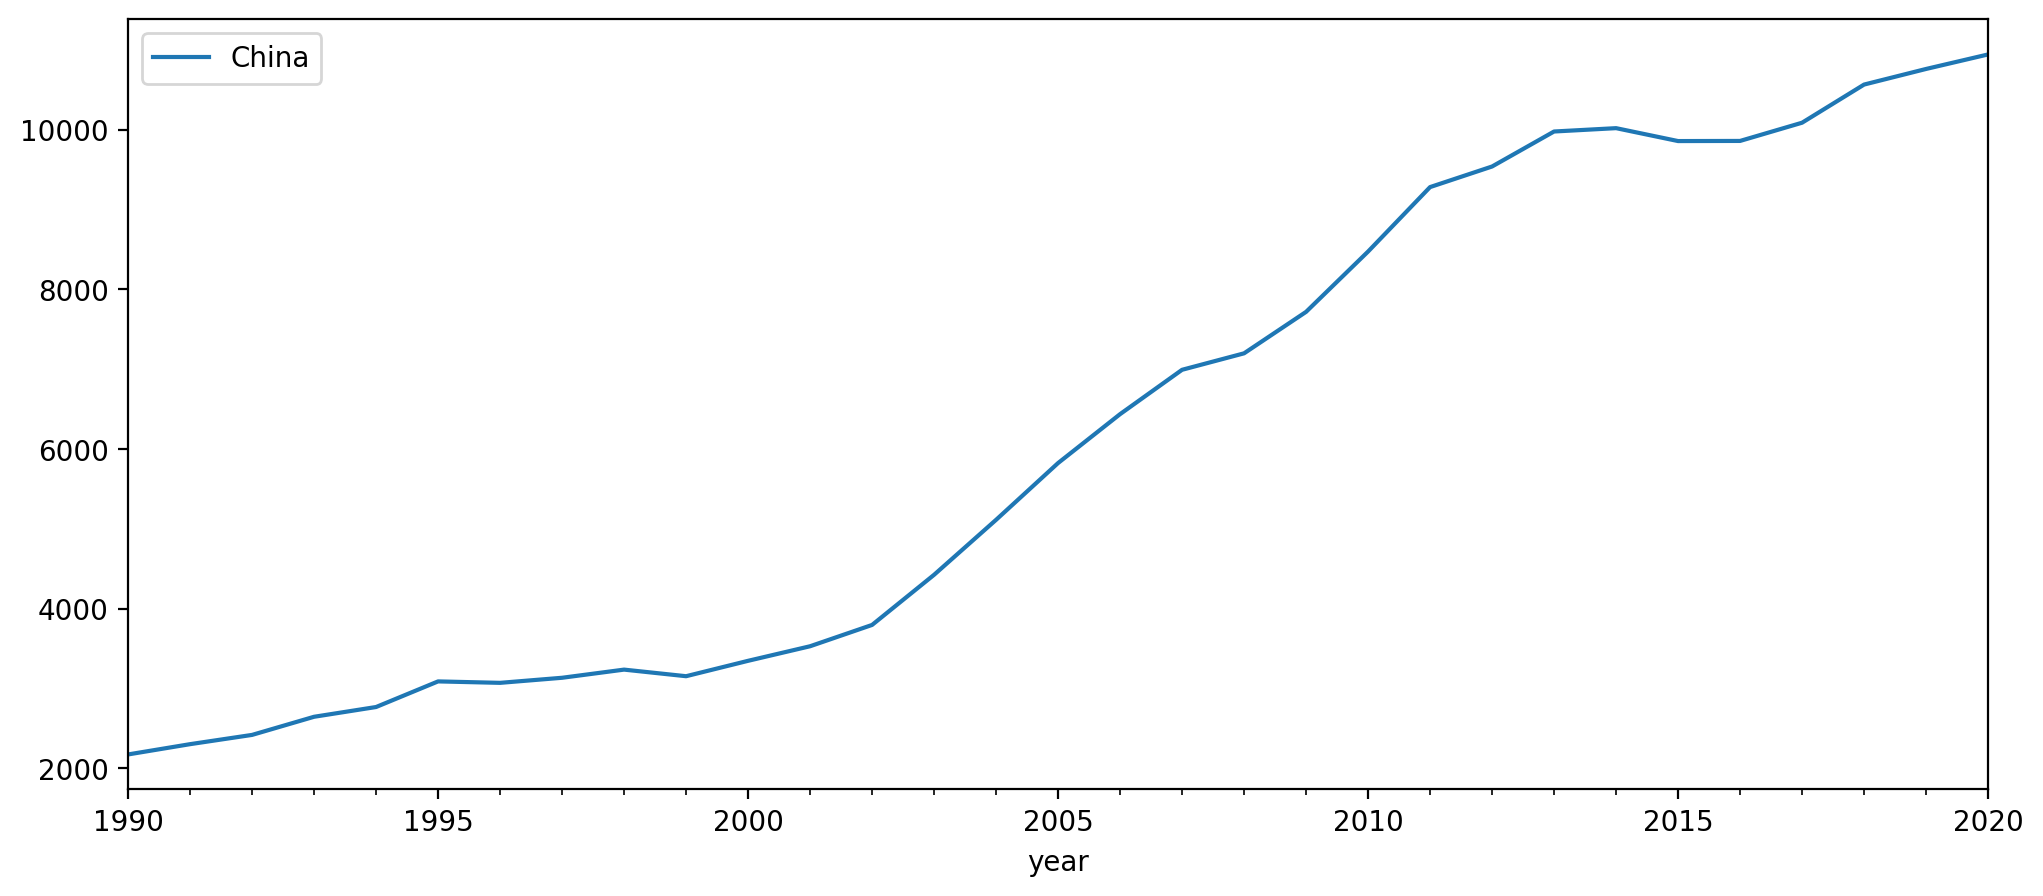

In [6]:
fig = plt.figure(dpi=200)
df1.plot(figsize=(12,5),ax = plt.gca())

## Automate the augmented Dickey-Fuller Test
Since we'll be using it a lot to determine if an incoming time series is stationary, let's write a function that performs the augmented Dickey-Fuller Test.

In [7]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

### Run an ETS Decomposition (optional)
We probably won't learn a lot from it, but it never hurts to run an ETS Decomposition plot.

<Figure size 2400x1000 with 0 Axes>

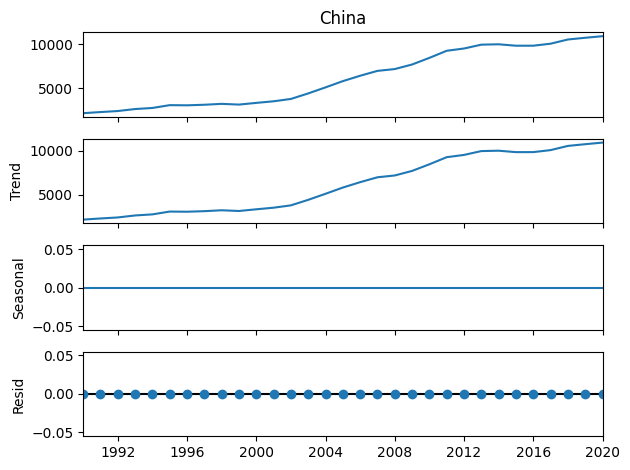

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose


result = seasonal_decompose(df1['China'], model='additive')  # model='add' also works
fig = plt.figure(dpi=200,figsize=(12,5))
result.plot();

Here we see that the seasonal component does not contribute significantly to the behavior of the series.
### Use <tt>pmdarima.auto_arima</tt> to determine ARIMA Orders

In [12]:
auto_arima(df1['China'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -202.229
Date:                Mon, 03 Jul 2023   AIC                            410.457
Time:                        19:38:08   BIC                            414.661
Sample:                    01-01-1990   HQIC                           411.802
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    109.7525     69.343      1.583      0.113     -26.158     245.663
ar.L1          0.6029      0.154      3.926      0.000       0.302       0.904
sigma2      4.046e+04   1.48e+04      2.731      0.006    1.14e+04    6.95e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 1.44
Prob(Q):                              0.82   Prob(JB):                         0.49
Heteroskedasticity (H):               1.96   Skew:                            -0.14
Prob(H) (two-sided):                  0.30   Kurtosis:                         1.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Run the augmented Dickey-Fuller Test on the First Difference

In [13]:
from statsmodels.tsa.statespace.tools import diff
df1['d2'] = diff(df1['China'],k_diff=2)

# Equivalent to:
# df1['d1'] = df1['China'] - df1['China'].shift(1)

adf_test(df1['d2'],'Real time difference in CO2 Emissions')

Augmented Dickey-Fuller Test: Real time difference in CO2 Emissions
ADF test statistic     -6.081184e+00
p-value                 1.091232e-07
# lags used             0.000000e+00
# observations          2.800000e+01
critical value (1%)    -3.688926e+00
critical value (5%)    -2.971989e+00
critical value (10%)   -2.625296e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [14]:
df1.head()

,China,d2
year,,
1990-01-01,2173.36,NaN
1991-01-01,2302.19,NaN
1992-01-01,2418.18,-12.84
1993-01-01,2645.41,111.24
1994-01-01,2767.67,-104.97


This confirms that we reached stationarity after the Second difference.
### Run the ACF and PACF plots
A <strong>PACF Plot</strong> can reveal recommended AR(p) orders, and an <strong>ACF Plot</strong> can do the same for MA(q) orders.<br>
Alternatively, we can compare the stepwise <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'>Akaike Information Criterion (AIC)</a> values across a set of different (p,q) combinations to choose the best combination.

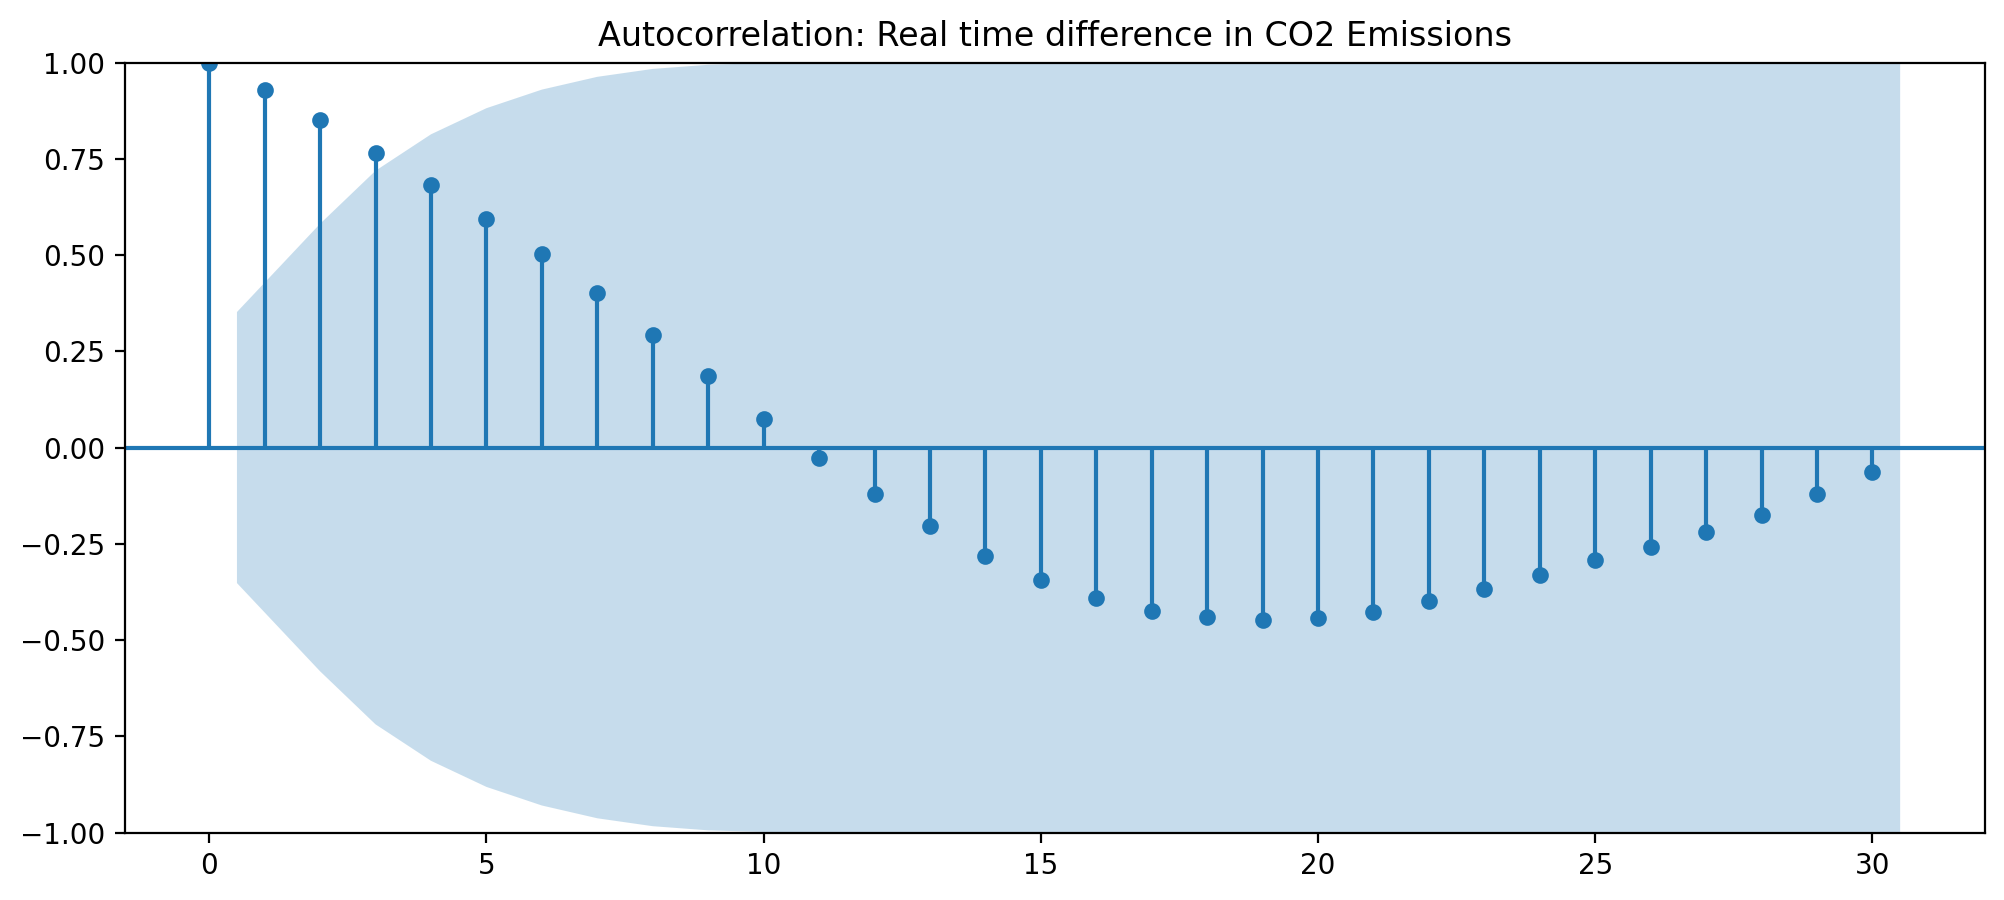

In [16]:
fig = plt.figure(dpi=200,figsize=(12,5))
title = 'Autocorrelation: Real time difference in CO2 Emissions'
xlabel = 'lags'
ylabel = 'plot difference range'
lags = 30
plot_acf(df1['China'],title=title,lags=lags,ax = plt.gca());



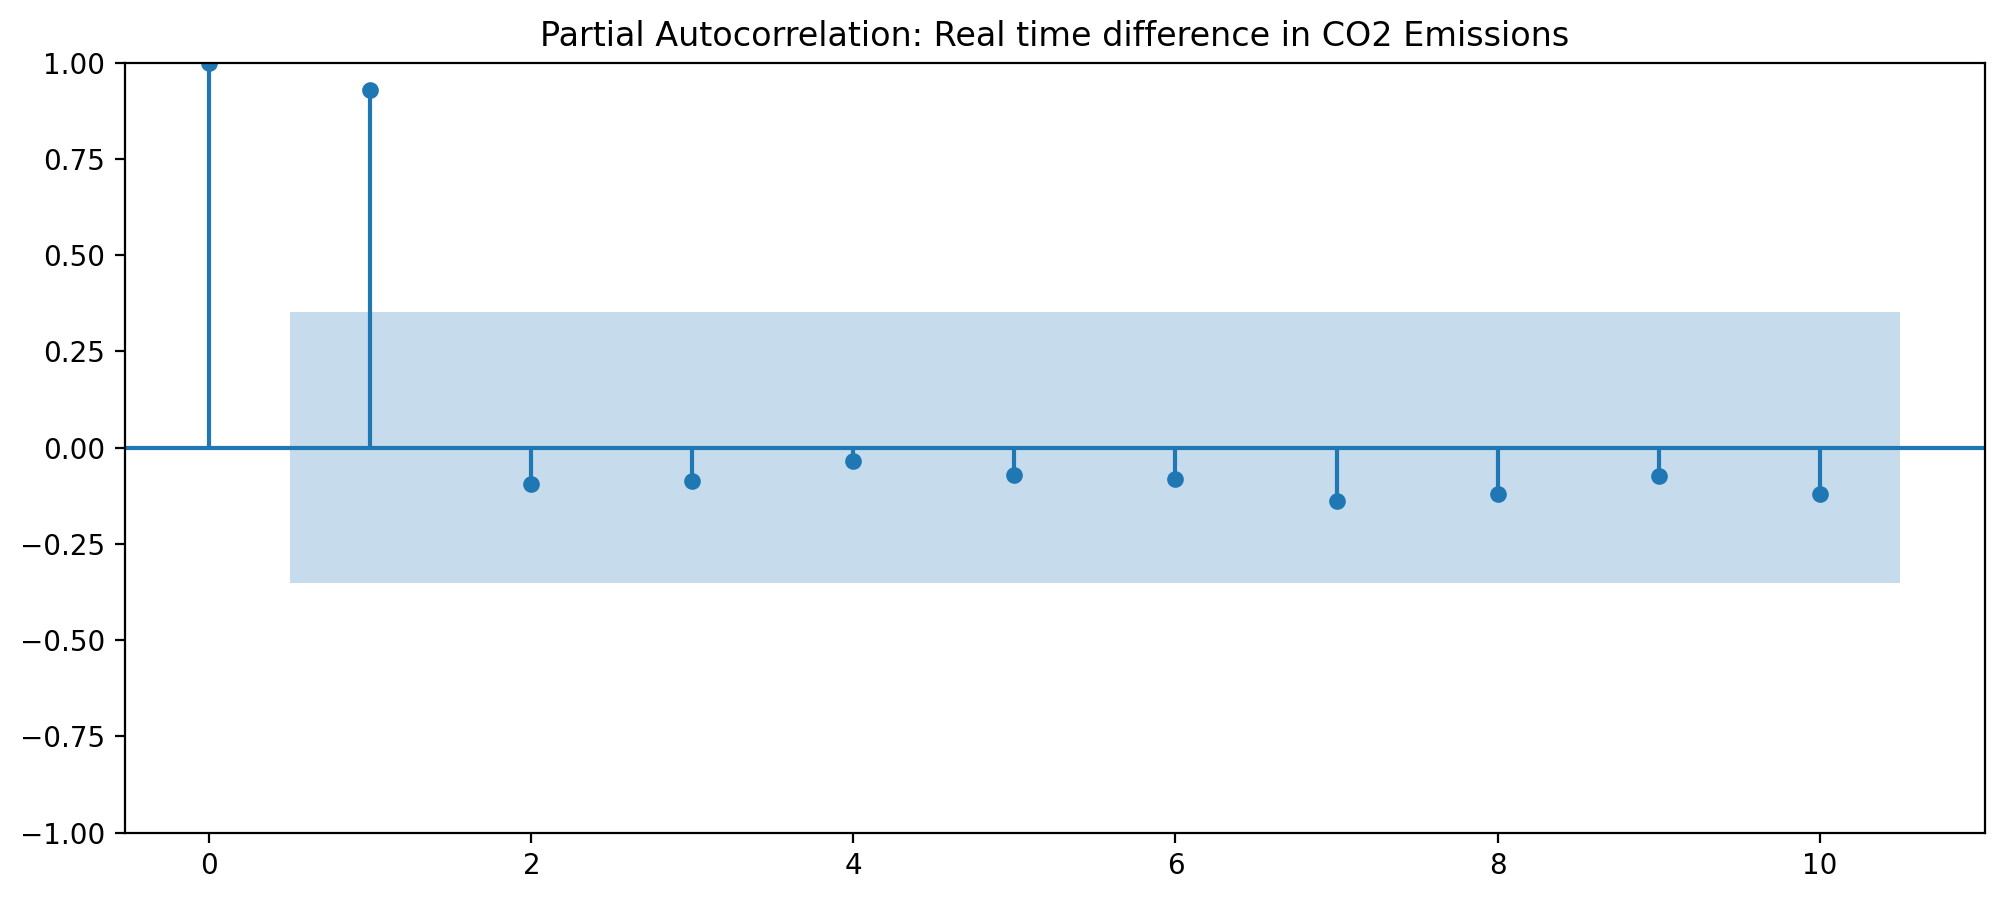

In [20]:
fig = plt.figure(dpi=200,figsize=(12,5))
title = 'Partial Autocorrelation: Real time difference in CO2 Emissions'
lags = 10
plot_pacf(df1['China'],title=title,lags=lags,ax=plt.gca());

This tells us that the AR component should be more important than MA. From the <a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:<br>
> <em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms.</em><br>

Let's take a look at <tt>pmdarima.auto_arima</tt> done stepwise to see if having $p$ and $q$ terms the same still makes sense:

In [21]:
stepwise_fit = auto_arima(df1['China'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=422.852, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=410.457, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=414.503, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=445.332, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=412.443, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=412.455, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=414.449, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=412.037, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.100 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -202.229
Date:                Mon, 03 Jul 2023   AIC                            410.457
Time:                        19:39:24   BIC                            414.661
Sample:                    01-01-1990   HQIC                           411.802
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    109.7525     69.343      1.583      0.113     -26.158     245.663
ar.L1          0.6029      0.154      3.926      0.000       0.302       0.904
sigma2      4.046e+04   1.48e+04      2.731      0.006    1.14e+04    6.95e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 1.44
Prob(Q):                              0.82   Prob(JB):                         0.49
Heteroskedasticity (H):               1.96   Skew:                            -0.14
Prob(H) (two-sided):                  0.30   Kurtosis:                         1.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Looks good from here! Now let's train & test the ARIMA(1,1,1) model, evaluate it, then produce a forecast of future values.
### Split the data into train/test sets

In [22]:
len(df1)-5

26

In [23]:
# Set five years for testing
train = df1.iloc[:25]
test = df1.iloc[25:]

In [24]:
model1 = ARIMA(train['China'],order=(5,2,2))
results1 = model1.fit()
results1.summary()


model2 = ARIMA(train['China'],order=(5,3,2))
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  China   No. Observations:                   25
Model:                 ARIMA(5, 3, 2)   Log Likelihood                -151.373
Date:                Mon, 03 Jul 2023   AIC                            318.746
Time:                        19:39:45   BIC                            327.474
Sample:                    01-01-1990   HQIC                           320.802
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5706      1.440     -0.396      0.692      -3.393       2.252
ar.L2         -0.3613      0.625     -0.578      0.564      -1.587       0.865
ar.L3         -0.4276      0.462     -0.925      0.355      -1.334       0.479
ar.L4         -0.4201      0.580     -0.724      0.469      -1.557       0.717
ar.L5         -0.3891      0.538     -0.724      0.469      -1.443       0.665
ma.L1         -0.5905      1.398     -0.422      0.673      -3.331       2.150
ma.L2          0.0609      1.356      0.045      0.964      -2.597       2.719
sigma2      4.942e+04   1.94e+04      2.543      0.011    1.13e+04    8.75e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 1.95
Prob(Q):                              0.75   Prob(JB):                         0.38
Heteroskedasticity (H):               3.09   Skew:                            -0.72
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
print(results1.summary().tables[0]),
print(results1.summary().tables[1]),
print(results1.summary().tables[2])


                               SARIMAX Results                                
Dep. Variable:                  China   No. Observations:                   25
Model:                 ARIMA(5, 2, 2)   Log Likelihood                -155.430
Date:                Mon, 03 Jul 2023   AIC                            326.861
Time:                        19:39:46   BIC                            335.944
Sample:                    01-01-1990   HQIC                           329.145
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0642      3.244      0.020      0.984      -6.295       6.423
ar.L2         -0.6916      1.307     -0.529      0.597      -3.254       1.871
ar.L3         -0.4007      0.413     -0.971      0.3

In [26]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions1 = results1.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(5,2,2) Predictions')
predictions2 = results2.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(5,3,2) Predictions')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

In [27]:
# Compare predictions to expected values
print('Predictions for ARIMA(5,2,2)') 
for i in range(len(predictions1)):
    print(f"predicted={predictions1[i]:<11.10}, expected={test['China'][i]}")
    
print('Predictions for ARIMA(5,3,2)')   
for i in range(len(predictions2)):
    print(f"predicted={predictions2[i]:<11.10}, expected={test['China'][i]}")    

Predictions for ARIMA(5,2,2)
predicted=10226.01193, expected=9859.28
predicted=10606.24591, expected=9860.91
predicted=11099.0698 , expected=10089.27
predicted=11468.81564, expected=10567.26
predicted=11715.16387, expected=10762.82
predicted=11926.78118, expected=10944.69
Predictions for ARIMA(5,3,2)
predicted=10180.39721, expected=9859.28
predicted=10376.67741, expected=9860.91
predicted=10644.11098, expected=10089.27
predicted=10730.86213, expected=10567.26
predicted=10811.28227, expected=10762.82
predicted=10696.03667, expected=10944.69


[Text(0.5, 0, 'lags'), Text(0, 0.5, 'CO2 Emissions in Million tons')]

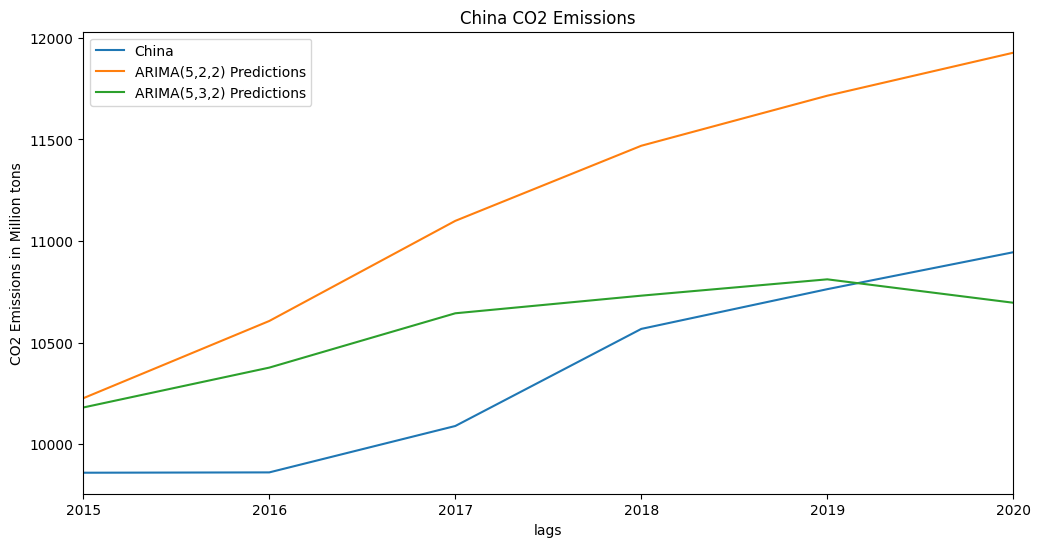

In [28]:
# Plot predictions against known values
title = 'China CO2 Emissions'
ylabel='CO2 Emissions in Million tons'
xlabel='lags' # we don't really need a label here

ax = test['China'].plot(legend=True,figsize=(12,6),title=title)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

### Evaluate the Model

In [29]:
from sklearn.metrics import mean_squared_error

error1 = mean_squared_error(test['China'], predictions1)
print(f'ARIMA(5,2,2) MSE Error: {error1:11.10}')

error2 = mean_squared_error(test['China'], predictions2)
print(f'ARIMA(5,3,2) MSE Error: {error2:11.10}')

ARIMA(5,2,2) MSE Error: 732329.6817
ARIMA(5,3,2) MSE Error: 127987.2534


In [30]:
from statsmodels.tools.eval_measures import rmse

error1 = rmse(test['China'], predictions1)
print(f'ARIMA(5,2,2) RMSE Error: {error1:11.10}')

error2 = rmse(test['China'], predictions2)
print(f'ARIMA(5,3,2) RMSE Error: {error2:11.10}')

ARIMA(5,2,2) RMSE Error: 855.7626316
ARIMA(5,3,2) RMSE Error:  357.753062


<Axes: xlabel='year'>

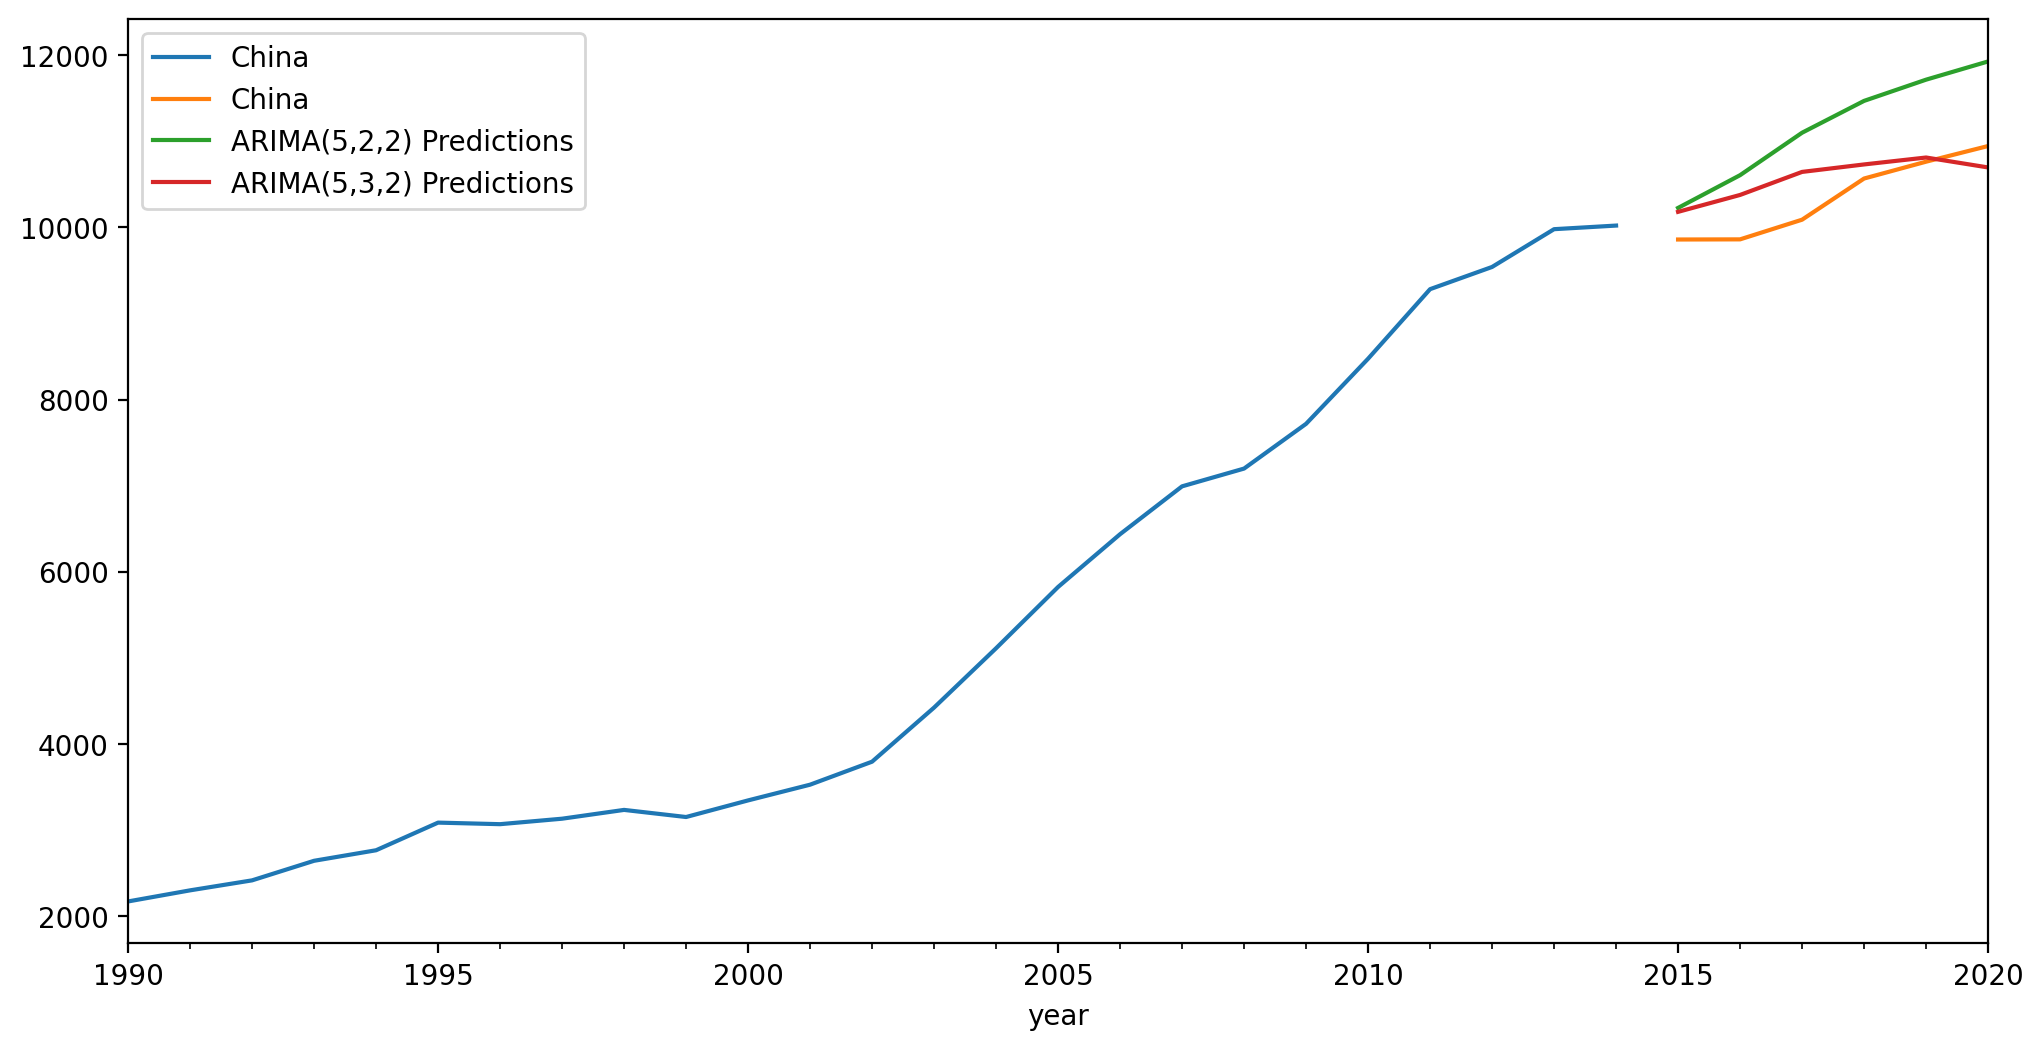

In [31]:
fig = plt.figure(dpi=200)
train['China'].plot(legend=True)
test['China'].plot(legend=True)
predictions1.plot(legend=True,figsize=(12,6))
predictions2.plot(legend=True,figsize=(12,6))

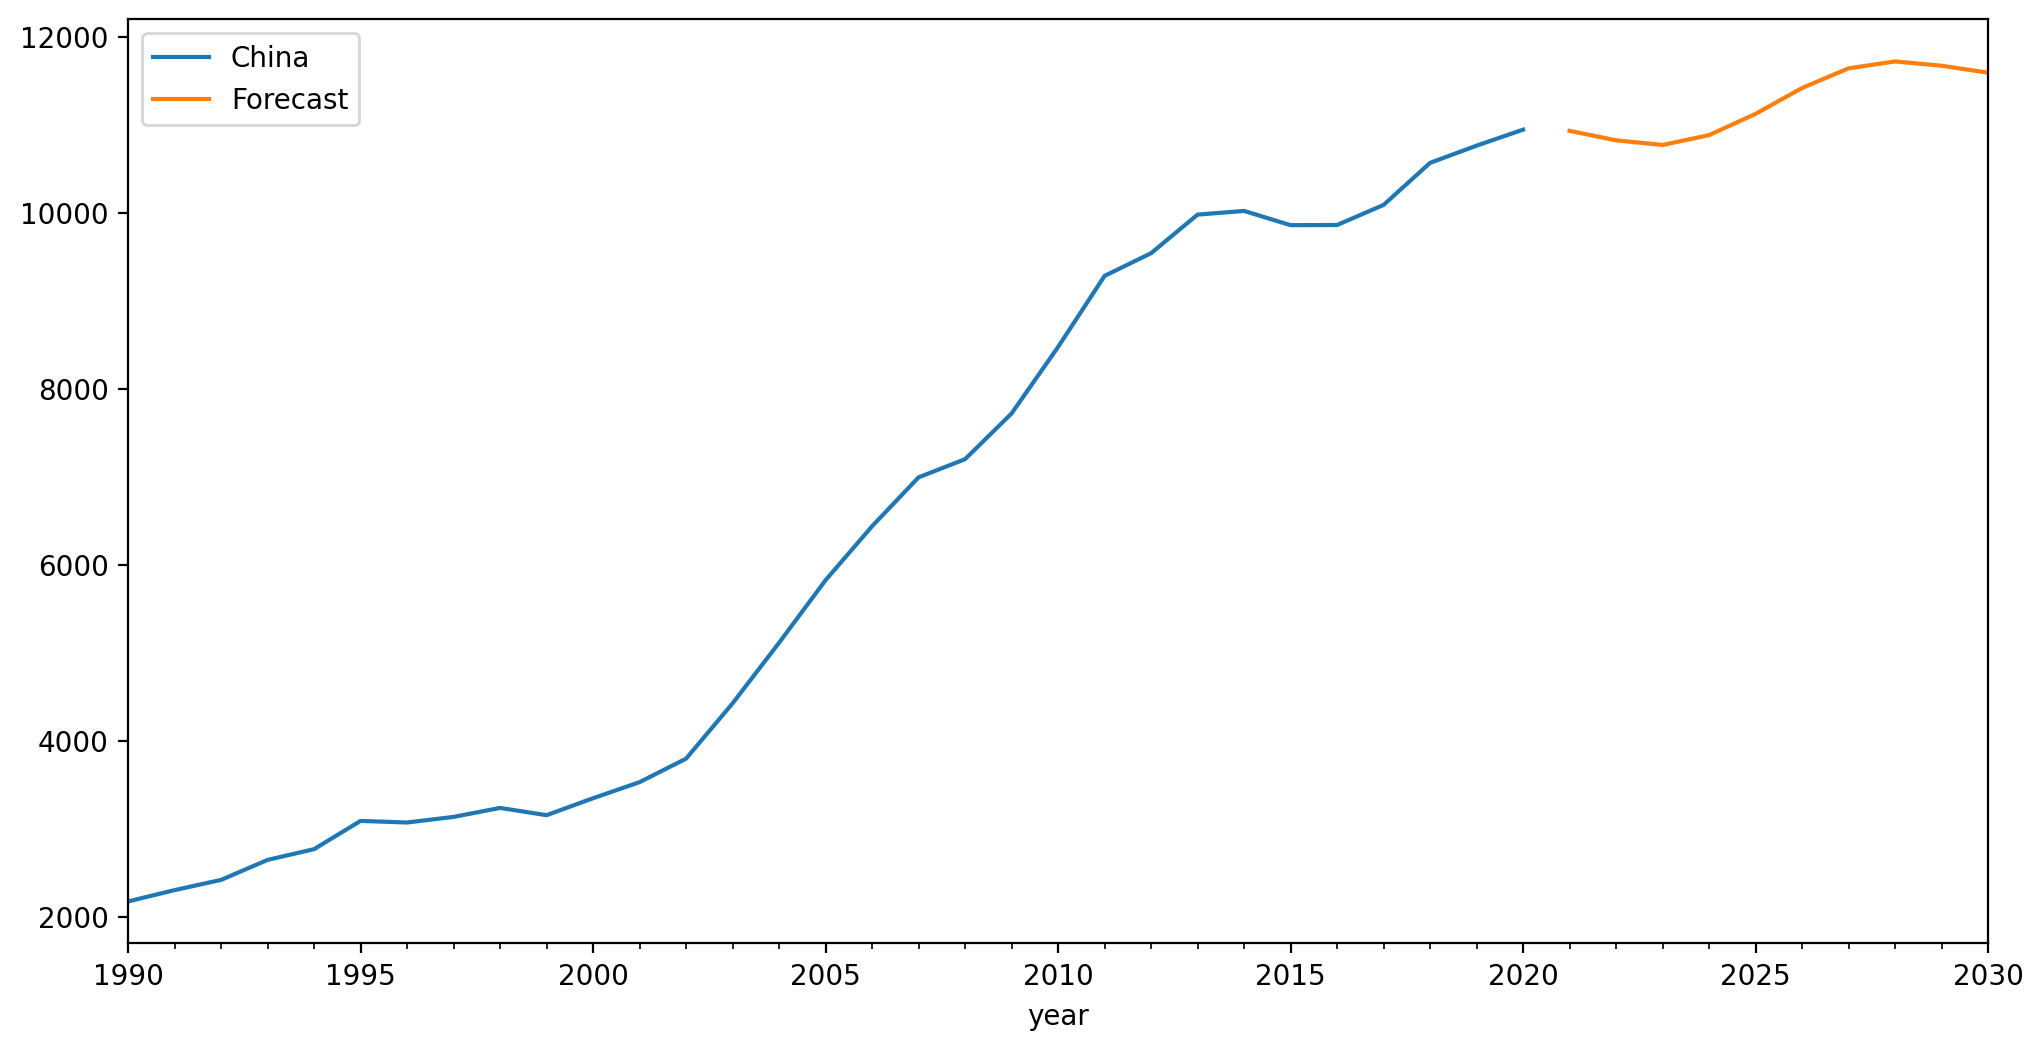

In [33]:
# First, retrain the model on the full dataset
ARIMAfit = ARIMA(df1['China'],order=(5,3,2)).fit()

# Make predictions

fcast = ARIMAfit.predict(start=len(df), end=len(df)+9, dynamic=False).rename('Forecast')
pred = ARIMAfit.get_prediction(start=len(df), end=len(df)+9, dynamic=False)
pred_ci = pred.conf_int(0.001)

# Plot the results

fig = plt.figure(dpi=200, figsize=(12,6))

df1['China'].plot(legend=True,ax = plt.gca())
fcast.plot(legend=True,ax = plt.gca())
plt.show();



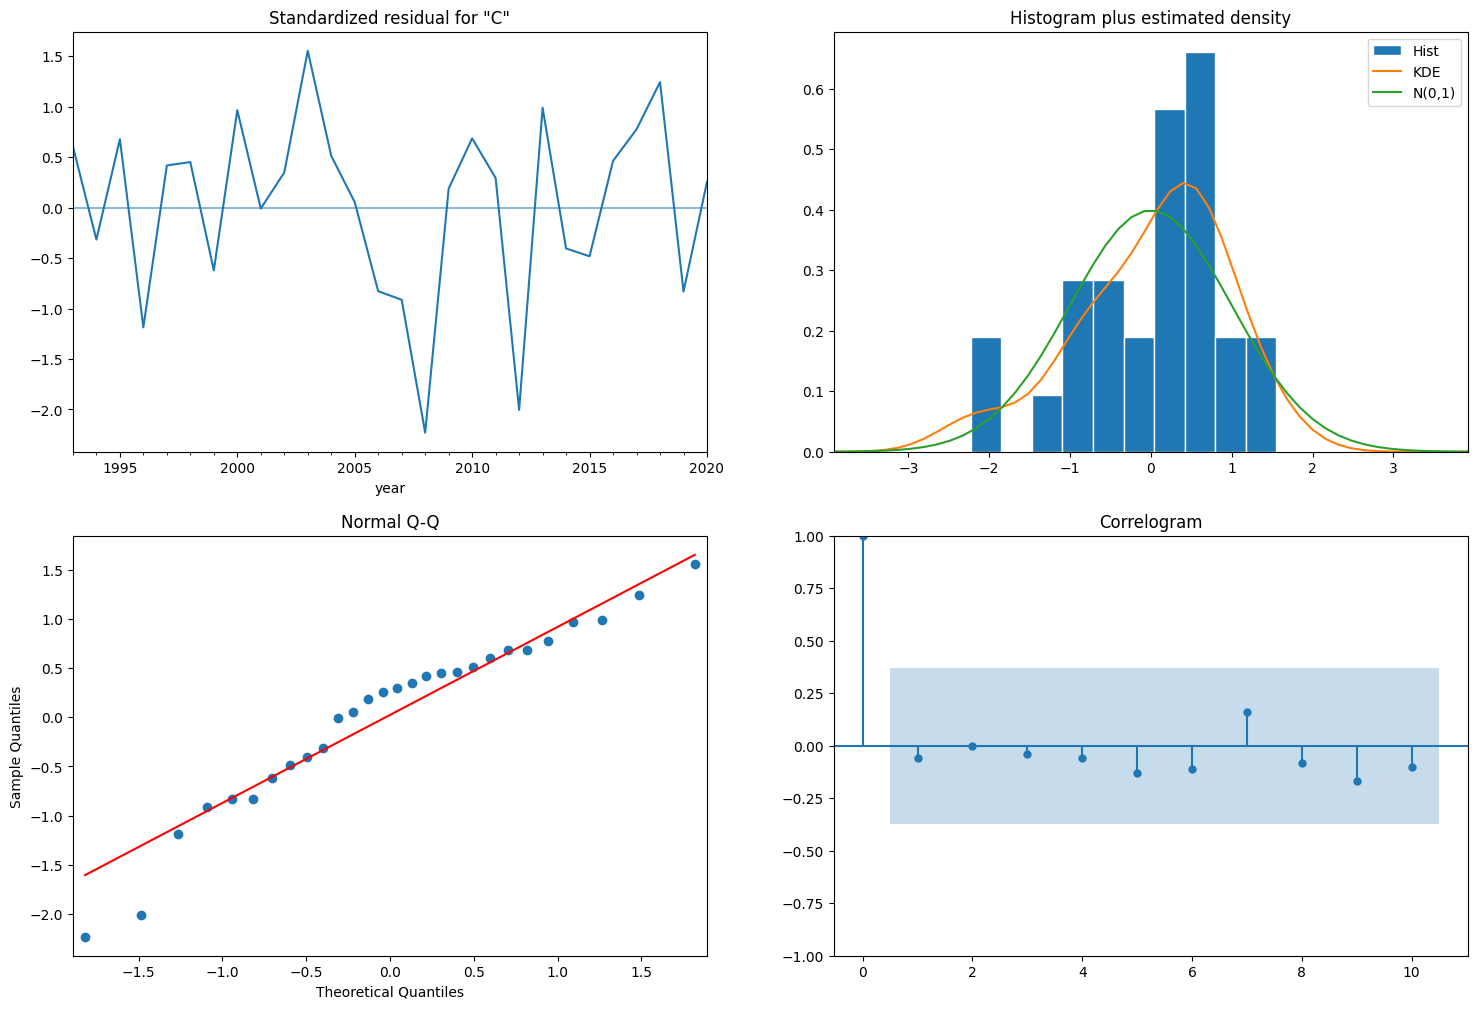

In [45]:
ARIMAfit.plot_diagnostics(figsize=(18,12))
plt.show()